In [3]:
import pandas as pd
test_csv = pd.read_csv('../raw_data/Amharic_Data/test/all_test.csv')
train_csv = pd.read_csv('../raw_data/Amharic_Data/train/all_train.csv')

In [4]:
all_text = ''.join(test_csv['line_text'].tolist() + train_csv['line_text'].tolist())

In [5]:
vocab = set(all_text)


In [8]:
CHARS = ''.join(sorted(vocab))

In [9]:
print(len(CHARS))

380


In [10]:
import os
import glob

import torch
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
import cv2
from PIL import Image
import numpy as np


class MyDataset(Dataset):
    CHARS = ''.join(sorted(vocab))
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, root_dir=None, mode=None, df=None, img_height=80, img_width=364):
       

        self.paths = df['image_filename'].tolist()
        self.texts = df['line_text'].tolist()
        self.img_height = img_height
        self.img_width = img_width
        self.root_dir = root_dir

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = os.path.join(self.root_dir, self.paths[index])

        try:
            image = Image.open(path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % index)
            return self[index + 1]

        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)
        if self.texts:
            text = self.texts[index].strip()
            
            target = [self.CHAR2LABEL[c] for c in text]
            target_length = [len(target)]

            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)
            return image, target, target_length
        else:
            return image


def my_collate_fn(batch):
    images, targets, target_lengths = zip(*batch)
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    return images, targets, target_lengths

In [11]:
from __future__ import annotations
from typing import List, Tuple, Sequence
class LabelConverter:
    """String ⇄ index-tensor converter for CTC.

    ● blank index = 0
    ● char indices start at 1 → len(charset) + 1 classes in the model.
    """

    def __init__(self, charset: str):
        self.charset   = charset
        self.blank     = 0
        self.char2idx  = {c: i + 1 for i, c in enumerate(charset)}  # 1‑based
        self.idx2char  = {i + 1: c for i, c in enumerate(charset)}

    # --------------------------- Encode ------------------------------------ #
    def encode(self, texts: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        lengths = torch.tensor([len(t) for t in texts], dtype=torch.long)
        flat    = torch.tensor([self.char2idx[c] for t in texts for c in t], dtype=torch.long)
        return flat, lengths

    # --------------------------- Decode log‑probs --------------------------- #
    @torch.no_grad()
    def decode(self, log_probs: torch.Tensor, raw: bool = False) -> List[str]:
        """Greedy decode from model output (T, B, C)."""
        best = log_probs.argmax(2).permute(1, 0)  # (B,T)
        return self.decode_indices(best, remove_repeats=True, raw=raw)

    # --------------------------- Decode raw indices ------------------------ #
    def decode_indices(
        self,
        sequences: Sequence[Sequence[int]] | torch.Tensor,
        *,
        remove_repeats: bool = False,
        raw: bool = True,
    ) -> List[str]:
        """Convert index sequences → strings.

        Parameters
        ----------
        sequences : (B,T) tensor or list of lists containing *model indices* (0 = blank).
        remove_repeats : drop consecutive duplicate indices (CTC best‑path post‑process).
        raw   : if True, return the indices as space‑separated strings instead of chars.
        """
        if isinstance(sequences, torch.Tensor):
            sequences = sequences.tolist()

        out: List[str] = []
        for seq in sequences:
            chars: List[str] = []
            prev: int | None = None
            for idx in seq:
                if isinstance(idx, torch.Tensor):
                    idx = idx.item()
                if idx != self.blank:
                    if raw:
                        chars.append(str(idx))
                    else:
                        
                        chars.append(self.idx2char.get(idx, ""))
               
            out.append(" ".join(chars) if raw else "".join(chars))
        return out

In [53]:

data_type = "synthetic"
# Assuming your DataFrame is named `df`
typed_df = train_csv[train_csv['type'] == data_type]

In [13]:
len(typed_df)

22418

In [14]:
len(train_csv[train_csv['type'] == 'handwritten'])

34820

In [73]:
test_filter = "hdd_18"

test_df = test_csv[test_csv['type'] == test_filter][100:101] 

# test_df_1 = test_csv[test_csv['type'] == 'hdd_18'] 
# test_df_2 = test_csv[test_csv['type'] == 'hdd_rand'] 
# # test_df_3 = test_csv[test_csv['type'] == 'handwritten'] 
# test_df = pd.concat([test_df_1, test_df_2], ignore_index=True)
# # test_df = pd.concat([test_df_1, test_df_2, test_df_3], ignore_index=True)

In [74]:
len(test_df)

1

In [75]:
converter = LabelConverter(MyDataset.CHARS)

In [76]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(typed_df, test_size=0.2, random_state=42, shuffle=True)


In [77]:
img_width = 1000
img_height = 100
data_dir_train =  '/home/admin/Gabby/Amharic OCR/HandWritten_Amharic_English_OCR/raw_data/Amharic_Data/train'
data_dir_test =  '/home/admin/Gabby/Amharic OCR/HandWritten_Amharic_English_OCR/raw_data/Amharic_Data/test'

In [78]:
train_dataset =MyDataset(root_dir=data_dir_train, mode='train',
                                    df=train_df, img_height=img_height, img_width=img_width)
valid_dataset = MyDataset(root_dir=data_dir_train, mode='valid',
                                    df=val_df, img_height=img_height, img_width=img_width)
test_dataset = MyDataset(root_dir=data_dir_test, mode='valid',
                                    df=test_df, img_height=img_height, img_width=img_width)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    collate_fn=my_collate_fn,
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4,
    collate_fn=my_collate_fn,
)

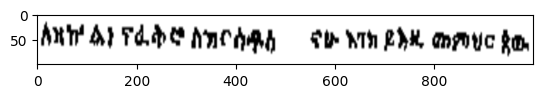

In [79]:
import matplotlib.pyplot as plt
image = test_dataset.__getitem__(0)[0]
image = image.squeeze(0).numpy()


plt.imshow(image, cmap='gray')


Image 0 shape: torch.Size([1, 100, 1000])
Target indices: [72, 239, 212, 77, 180, 348, 183, 330, 131, 108, 348, 72, 209, 107, 115, 159, 115, 348, 183, 66, 348, 201, 185, 209, 348, 260, 201, 241, 348, 87, 92, 70, 107, 348, 310, 229]
Decoded text: ['ለዘኲልነ፡ናፈቅሮ፡ለክርስቶስ፡ናሁ፡እንክ፡ይእዚ፡መምህር፡ጳው']
ለዘኲልነ፡ናፈቅሮ፡ለክርስቶስ፡ናሁ፡እንክ፡ይእዚ፡መምህር፡ጳው


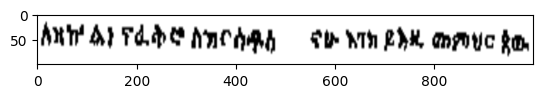

In [81]:
for images, targets, target_lengths in test_loader:
    
    batch_size = images.size(0)
    
    # Split targets back using target_lengths
    split_targets = torch.split(targets, target_lengths.tolist())

    for i in range(batch_size):
        img = images[i]
        target_tensor = split_targets[i]  # 1D tensor of label indices for this sample
        plt.imshow(img.squeeze(0).numpy(), cmap='gray')
        print(f"Image {i} shape: {img.shape}")
        print(f"Target indices: {target_tensor.tolist()}")
        
        # Optionally decode target_tensor using your label converter
        decoded_text = converter.decode_indices([target_tensor], raw=False)
        print(f"Decoded text: {decoded_text}")
        print(" ".join(decoded_text))
        
        break  # remove or modify to check more
    break

### Modeling

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CRNN(nn.Module):
    def __init__(self, num_classes: int, hidden_size: int = 256):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(True),
            nn.Conv2d(256, 256, 3, 1, 1), nn.ReLU(True), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(True),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(512, 512, 3, 1, 1), nn.ReLU(True),
            nn.AdaptiveAvgPool2d((1, None)),
        )
        self.map_to_seq = nn.Linear(512, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.
        Accepts (B,1,80,W) and outputs CTC‑ready log‑probs (T, B, C).
        We **average over the height dimension** instead of squeezing so we
        never hit a dim‑mismatch even if `AdaptiveAvgPool2d` leaves H>1 on
        some PyTorch builds.
        """
        feats = self.cnn(x)              # (B, 512, H', W')
        feats = feats.mean(2)            # collapse H' → (B, 512, W')
        feats = feats.permute(0, 2, 1)   # (B, W', 512)
        seq, _ = self.rnn(self.map_to_seq(feats))
        logits = self.classifier(seq)    # (B, W', C)
        log_probs = F.log_softmax(logits, dim=-1)  # (B,W',C)
        return log_probs.permute(1, 0, 2)  

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
model = CRNN(len(MyDataset.CHARS)+1).to(device)


In [26]:
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [27]:
def _levenshtein(a: str, b: str) -> int:
    if a == b:
        return 0
    if len(a) < len(b):
        a, b = b, a
    prev = list(range(len(b) + 1))
    for i, ca in enumerate(a, 1):
        cur = [i]
        for j, cb in enumerate(b, 1):
            cur.append(min(prev[j]+1,      # deletion
                            cur[-1]+1,     # insertion
                            prev[j-1] + (ca != cb)))  # substitution
        prev = cur
    return prev[-1]


def _update_char_counts(pred: str, gt: str):
    dist = _levenshtein(pred, gt)
    tp = len(gt) - dist  # correct chars = ground truth − edit distance
    return tp, len(pred), len(gt)

def _split_targets(targets: torch.Tensor, lengths: torch.Tensor) -> List[List[int]]:
    out, ptr = [], 0
    for l in lengths:
        out.append(targets[ptr:ptr+l].tolist())
        ptr += l
    return out

In [28]:
import json
from tqdm.auto import tqdm
from collections import Counter

def run_epoch(model, loader, crit, opt, device, conv, *, train=True,
              save_samples: bool=False, sample_count: int=20,
              log_dir: str="logs", epoch_idx: int=0,
              best_cer: float=float("inf")) -> Tuple[dict, float]:
    os.makedirs(log_dir, exist_ok=True)
    model.train() if train else model.eval()
    name = "train" if train else "val"
    bar = tqdm(loader, desc=f"[{name}]", leave=False)

    tot_loss = tot_ed = tot_wed = 0
    tp_char = pred_tot = gt_tot = 0
    tp_word = 0
    samples = []
    tp_word = fp_word = fn_word = 0  
    for imgs, tgt, tlen in bar:
        imgs, tgt, tlen = imgs.to(device), tgt.to(device), tlen.to(device)
        with torch.set_grad_enabled(train):
            logp = model(imgs)
            in_len = torch.full((imgs.size(0),), logp.size(0), dtype=torch.long, device=device)
            loss = crit(logp, tgt, in_len, tlen)
            if train:
                opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        # metrics
        gts  = conv.decode_indices(_split_targets(tgt.cpu(), tlen.cpu()), remove_repeats=False)
        gts = [list(map(int, g.split())) for g in gts]
        gts = conv.decode_indices(gts, raw=False)
        
     
        preds= conv.decode(logp.detach().cpu())
        for p, g in zip(preds, gts):
            if save_samples and len(samples) < sample_count:
                samples.append({"gt": g, "pred": p})

            # Levenshtein for CER and WER
            ed = _levenshtein(p, g)
            tot_ed += ed
            tot_wed += _levenshtein(p.split(), g.split())

            # Char-level stats
            tp_char += len(g) - ed
            pred_tot += len(p)
            gt_tot += len(g)

            # Word-level stats
            p_words = p.split()
            g_words = g.split()
            p_counter = Counter(p_words)
            g_counter = Counter(g_words)

            for word in p_counter:
                tp_word += min(p_counter[word], g_counter.get(word, 0))
                fp_word += max(0, p_counter[word] - g_counter.get(word, 0))
            for word in g_counter:
                fn_word += max(0, g_counter[word] - p_counter.get(word, 0))

            tot_loss += loss.item()
            bar.set_postfix(loss=loss.item())

    cer = tot_ed/max(1,gt_tot)
    wer = tot_wed/max(1,gt_tot)
    prec = tp_char/pred_tot if pred_tot else 0; rec = tp_char/gt_tot if gt_tot else 0
    f1c = 2*prec*rec/(prec+rec) if prec+rec else 0
    word_prec = tp_word / (tp_word + fp_word + 1e-8)
    word_rec = tp_word / (tp_word + fn_word + 1e-8)
    f1w = 2 * word_prec * word_rec / (word_prec + word_rec + 1e-8)
    stats = dict(loss=tot_loss/len(loader), CER=cer, WER=wer, F1_char=f1c, F1_word=f1w)

    # ── save sample predictions
    if save_samples:
        samp_path = os.path.join(log_dir, f"samples_epoch{epoch_idx}.json")
        with open(samp_path, "w", encoding="utf8") as f:
            json.dump(samples, f, ensure_ascii=False, indent=2)

    # ── checkpoint best CER
    if not train and cer < best_cer:
        ckpt = {
            "epoch": epoch_idx,
            "model": model.state_dict(),
            "optimizer": opt.state_dict(),
            "CER": cer,
        }
        torch.save(ckpt, os.path.join(log_dir, "best_cer.pt"))
        best_cer = cer

    return stats, best_cer

In [29]:
import wandb

# This prompts you to enter your API key the first time
wandb.login(key="7a2297338ed4c184a8cf1c11b29bd7f0f010f9e3")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/admin/.netrc
wandb: Currently logged in as: gzenchaa to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [83]:
model_name = "hd_ocr"
# wandb.init(project="Amharic OCR", name=model_name)

In [84]:
checkpoint = torch.load(f'{model_name}_logs/best_cer.pt')

In [85]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [86]:
#  # ── training loop ────────────────────────────────
# wandb.watch(model, log="all")
# epochs = 50
# LOG_DIR = f"{model_name}_logs"
# best_cer = float("inf")
# for epoch in range(1, epochs+1):
#     print(f"\nEpoch {epoch}/{epochs}")
#     train_stats , _ = run_epoch(model, train_loader, criterion, optimizer, device, converter, train=True,
#                            epoch_idx=epoch)
#     val_stats, best_cer = run_epoch(model, valid_loader, criterion, optimizer, device, converter,
#                                         train=False, save_samples=True, sample_count=10,
#                                         log_dir=LOG_DIR, epoch_idx=epoch, best_cer=best_cer)
#     print(f"train: {train_stats}\nval  : {val_stats}")
#     ## add T to train starts keys
#     train_stats = {f"train_{k}": v for k, v in train_stats.items()}
#     val_stats   = {f"val_{k}": v for k, v in val_stats.items()}
#     wandb.log({"epoch": epoch, **train_stats, **val_stats})

In [87]:
import json
from tqdm.auto import tqdm
from collections import Counter

def predict(model, loader, device, conv, ) -> Tuple[dict, float]:
    model.eval()
    name =  "test"
    bar = tqdm(loader, desc=f"[{name}]", leave=False)

    results = {'preds': [], 'gts': []}
    for imgs, tgt, tlen in bar:
        imgs, tgt, tlen = imgs.to(device), tgt.to(device), tlen.to(device)
        with torch.set_grad_enabled(False):
            logp = model(imgs)
            in_len = torch.full((imgs.size(0),), logp.size(0), dtype=torch.long, device=device)
           
        gts  = conv.decode_indices(_split_targets(tgt.cpu(), tlen.cpu()), remove_repeats=False)
        gts = [list(map(int, g.split())) for g in gts]
        gts = conv.decode_indices(gts, raw=False)
        
     
        preds= conv.decode(logp.detach().cpu())
        for p, g in zip(preds, gts):
            results['preds'].append(p)
            results['gts'].append(g)
        bar.set_postfix()
            
    result_df = pd.DataFrame(results)
    return result_df

test_results = predict(model, test_loader, device, converter)

[test]:   0%|          | 0/1 [00:00<?, ?it/s]

In [52]:
test_results.head()

,preds,gts
0,ሆነ ለጠየቀው ሁሉ እጁ ሰፊ መፍርም ምን አይነት ውለታ ነው ስሙ ...,ሆነ ለጠየቀው ሁሉ እጁ ሰፊ መፍርም ምን አይነት ውለታ ነው ስሙ ...


In [221]:
test_results = pd.read_csv("/home/admin/Gabby/Amharic OCR/HandWritten_Amharic_English_OCR/CRNN/ocr_predictions_typed.csv")

In [222]:
test_results['gts'] = test_results['ground_truth'].astype(str)
test_results['preds'] = test_results['prediction'].astype(str)

In [223]:
test_results.head()

,image_filename,ground_truth,prediction,gts,preds
0,typed_3642_line_6.png,የመቀሌ ከተማ መሆኑን ዘገባው አስነብቧል። ምንጮቹ በአከባቢያቸው...,የመቀሌ ከተማ መሆኑን ዘ7ባው አስነብቧል። ምንጮቹ በአከባቢያቸው ያለውን ...,የመቀሌ ከተማ መሆኑን ዘገባው አስነብቧል። ምንጮቹ በአከባቢያቸው...,የመቀሌ ከተማ መሆኑን ዘ7ባው አስነብቧል። ምንጮቹ በአከባቢያቸው ያለውን ...
1,typed_283_line_2.png,ነበር። ፈገግታ ከፊቷ የማይለያት ነጺ ፣ አባ ለማን እንዳሰቡሽ ...,ነበር። ፈ7ግታ ከፊቷ የማይለያት ነጺ ፣ አባ ለማን እንዳሰቡሽ ባወቅኹ አ...,ነበር። ፈገግታ ከፊቷ የማይለያት ነጺ ፣ አባ ለማን እንዳሰቡሽ ...,ነበር። ፈ7ግታ ከፊቷ የማይለያት ነጺ ፣ አባ ለማን እንዳሰቡሽ ባወቅኹ አ...
2,typed_283_line_3.png,ተመሳሳይ ዓላማና ግብ ይዣለሁ ብሎ የተበታተነ ድርጅት የሚገነባው...,ተመሳሳይ ዓላማና,ተመሳሳይ ዓላማና ግብ ይዣለሁ ብሎ የተበታተነ ድርጅት የሚገነባው...,ተመሳሳይ ዓላማና
3,typed_283_line_5.png,የሚያሰማውን ጩኸት ላለመስማት ጆሮውን የሚደፍን ሁሉ ፣ እሱ ራሱ ...,የሚያሰማውን ጩኸት ላለመስማት ጆሮውን የሚደፍን ሁሉ ፣ እሱ ራሱ ይጮኸል ...,የሚያሰማውን ጩኸት ላለመስማት ጆሮውን የሚደፍን ሁሉ ፣ እሱ ራሱ ...,የሚያሰማውን ጩኸት ላለመስማት ጆሮውን የሚደፍን ሁሉ ፣ እሱ ራሱ ይጮኸል ...
4,typed_3777_line_1.png,ዦክሃር ሳርናየቭ የተባለው የ 21 ዓመት ወጣት አሸባሪ ይህን ...,ዦክሃር ሳርናየቭ የተባለው የ 21 ዓመት ወጣት አሸባሪ ይህን ያስታወቀው ...,ዦክሃር ሳርናየቭ የተባለው የ 21 ዓመት ወጣት አሸባሪ ይህን ...,ዦክሃር ሳርናየቭ የተባለው የ 21 ዓመት ወጣት አሸባሪ ይህን ያስታወቀው ...


In [224]:
import numpy as np
import editdistance  # For calculating Levenshtein distance (for CER)

def calculate_metrics(test_df):
    # Initialize variables to store total errors and counts
    total_subs, total_deletions, total_insertions, total_words, total_chars = 0, 0, 0, 0, 0
    total_true_positive_words, total_false_positive_words, total_false_negative_words = 0, 0, 0
    total_true_positive_chars, total_false_positive_chars, total_false_negative_chars = 0, 0, 0
    
    for idx, row in test_df.iterrows():
        # Get ground truth and predicted text
        ground_truth = row['gts'].strip()
        prediction = row['preds'].strip()
        
        # Split ground truth and prediction into words
        gt_words = ground_truth.split()
        pred_words = prediction.split()
        
        # Calculate WER (Word Error Rate)
        # Using Levenshtein distance (edit distance) for word-level WER
        wer_result = editdistance.eval(gt_words, pred_words)
        total_subs += wer_result  # Substitutions in words
        total_deletions += len(gt_words) - len(pred_words)  # Deletions in words
        total_insertions += len(pred_words) - len(gt_words)  # Insertions in words
        total_words += len(gt_words)
        
        # Calculate F1 at word level
        true_positives_words = len(set(gt_words).intersection(pred_words))
        false_positives_words = len(pred_words) - true_positives_words
        false_negatives_words = len(gt_words) - true_positives_words
        
        total_true_positive_words += true_positives_words
        total_false_positive_words += false_positives_words
        total_false_negative_words += false_negatives_words
        
        # Calculate CER (Character Error Rate)
        gt_chars = ''.join(gt_words)
        pred_chars = ''.join(pred_words)
        
        # Using Levenshtein distance (edit distance) for character-level CER
        cer_result = editdistance.eval(gt_chars, pred_chars)
        total_subs += cer_result  # Substitutions in characters
        total_deletions += len(gt_chars) - len(pred_chars)  # Deletions in characters
        total_insertions += len(pred_chars) - len(gt_chars)  # Insertions in characters
        total_chars += len(gt_chars)
        
        # Calculate F1 at character level
        true_positives_chars = len(set(gt_chars).intersection(pred_chars))
        false_positives_chars = len(pred_chars) - true_positives_chars
        false_negatives_chars = len(gt_chars) - true_positives_chars
        
        total_true_positive_chars += true_positives_chars
        total_false_positive_chars += false_positives_chars
        total_false_negative_chars += false_negatives_chars
        
    # Calculate WER
    wer = (total_subs + total_deletions + total_insertions) / total_words if total_words > 0 else 0
    
    # Calculate CER
    cer = (total_subs + total_deletions + total_insertions) / total_chars if total_chars > 0 else 0
    
    # Calculate F1 Score at word level
    precision_word = total_true_positive_words / (total_true_positive_words + total_false_positive_words) if total_true_positive_words + total_false_positive_words > 0 else 0
    recall_word = total_true_positive_words / (total_true_positive_words + total_false_negative_words) if total_true_positive_words + total_false_negative_words > 0 else 0
    f1_word = (2 * precision_word * recall_word) / (precision_word + recall_word) if precision_word + recall_word > 0 else 0
    
    # Calculate F1 Score at character level
    precision_char = total_true_positive_chars / (total_true_positive_chars + total_false_positive_chars) if total_true_positive_chars + total_false_positive_chars > 0 else 0
    recall_char = total_true_positive_chars / (total_true_positive_chars + total_false_negative_chars) if total_true_positive_chars + total_false_negative_chars > 0 else 0
    f1_char = (2 * precision_char * recall_char) / (precision_char + recall_char) if precision_char + recall_char > 0 else 0
    
    return wer, cer, f1_word, f1_char



# Get metrics
wer, cer, f1_word, f1_char = calculate_metrics(test_results)

print(f"WER: {wer}")
print(f"CER: {cer}")
print(f"F1 Score (word-level): {f1_word}")
print(f"F1 Score (character-level): {f1_char}")


WER: 1.0063261285757887
CER: 0.2710552538488366
F1 Score (word-level): 0.7573435442410577
F1 Score (character-level): 0.5713504564685487


In [225]:
(7.30 + 1.62 + 1.06)/3

3.3266666666666667

In [226]:
(2.00 + 0.40 + 0.27)/3

0.89

In [228]:
(0.014 + 0.799 + 0.757)/3

0.5233333333333333

In [227]:
(0.036 + 0.5032 +0.57)/3

0.3697333333333333